# Notebook d'exploration – Flight Tracker Pro

Ce notebook propose une **exploration des données de vols** inspirée de l'API OpenSky Network.
Comme l'API est limitée et que l'application Streamlit fonctionne en temps réel, nous allons travailler ici avec
un **jeu de données fictif réaliste**, construit pour reproduire la structure et les comportements observés dans le projet.

On force notamment une répartition réaliste des phases de vol :
- environ **60%** des avions en croisière,
- environ **20%** en montée,
- environ **15%** en descente,
- environ **5%** au sol



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True


## 1. Construction d'un jeu de données fictif

Dans l'application, les données proviennent de l'endpoint `/states/all` de l'API OpenSky.
Ici, nous simulons un ensemble de vols en cours, avec des colonnes proches de celles utilisées dans le projet :

- `icao24` : identifiant unique de l'avion
- `callsign` : indicatif du vol (ex : AFR123)
- `origin_country` : pays d'origine
- `lat`, `lon` : position géographique
- `geo_altitude` : altitude (mètres)
- `velocity` : vitesse (m/s)
- `vertical_rate` : taux de montée/descente (m/s)
- `on_ground` : booléen indiquant si l'avion est au sol
- `true_track` : cap de l'avion (degrés)
- `status` : phase de vol (Montée, Descente, Croisière, Au sol)

On impose une répartition aléatoire mais *en moyenne* proche de : 60% croisière, 20% montée, 15% descente, 5% au sol.


In [3]:
np.random.seed(42)
n = 500  # nombre de vols fictifs

countries = ['France', 'Germany', 'Spain', 'Italy', 'United Kingdom', 'USA', 'UAE', 'Turkey', 'Netherlands', 'Qatar']
airline_codes = ['AFR', 'DLH', 'IBE', 'AZA', 'BAW', 'AAL', 'UAE', 'THY', 'KLM', 'QTR']

# Répartition des statuts : ~0.6 croisière, 0.2 montée, 0.15 descente, 0.05 sol
status_categories = ['Croisière', 'Montée', 'Descente', 'Au sol']
status_probs = [0.6, 0.2, 0.15, 0.05]
statuses = np.random.choice(status_categories, size=n, p=status_probs)

# Génération des variables de base
icao24 = [f"id{i:06d}" for i in range(n)]
callsign = [f"{random.choice(airline_codes)}{random.randint(10, 999)}" for _ in range(n)]
origin_country = [random.choice(countries) for _ in range(n)]
lat = np.random.uniform(30, 60, size=n)   # latitudes approximatives pour l'Europe / USA
lon = np.random.uniform(-20, 40, size=n)  # longitudes Europe / Atlantique
true_track = np.random.uniform(0, 360, size=n)

# Altitude & vitesse en fonction du statut
geo_altitude = np.zeros(n)
velocity = np.zeros(n)
vertical_rate = np.zeros(n)
on_ground = np.zeros(n, dtype=bool)

for i, s in enumerate(statuses):
    if s == 'Croisière':
        geo_altitude[i] = np.random.normal(loc=11000, scale=1500)  # m
        velocity[i] = np.random.normal(loc=240, scale=25)          # m/s
        vertical_rate[i] = np.random.normal(loc=0, scale=0.5)
        on_ground[i] = False
    elif s == 'Montée':
        geo_altitude[i] = np.random.normal(loc=7000, scale=2000)
        velocity[i] = np.random.normal(loc=220, scale=30)
        vertical_rate[i] = np.random.normal(loc=5, scale=1.5)      # positif
        on_ground[i] = False
    elif s == 'Descente':
        geo_altitude[i] = np.random.normal(loc=6000, scale=2500)
        velocity[i] = np.random.normal(loc=210, scale=30)
        vertical_rate[i] = np.random.normal(loc=-5, scale=1.5)     # négatif
        on_ground[i] = False
    else:  # 'Au sol'
        geo_altitude[i] = 0.0
        velocity[i] = np.random.normal(loc=15, scale=5)            # roulage au sol
        vertical_rate[i] = 0.0
        on_ground[i] = True

# On s'assure que les altitudes ne sont pas négatives
geo_altitude = np.clip(geo_altitude, 0, None)
velocity = np.clip(velocity, 0, None)

data = {
    'icao24': icao24,
    'callsign': callsign,
    'origin_country': origin_country,
    'lat': lat,
    'lon': lon,
    'geo_altitude': geo_altitude,
    'velocity': velocity,
    'vertical_rate': vertical_rate,
    'on_ground': on_ground,
    'true_track': true_track,
    'status': statuses,
}

df = pd.DataFrame(data)
df.head()


,icao24,callsign,origin_country,lat,lon,geo_altitude,velocity,vertical_rate,on_ground,true_track,status
0,id000000,QTR247,United Kingdom,50.944851,-8.892024,9683.026120,219.327991,-0.113239,False,186.869443,Croisière
1,id000001,IBE159,Italy,46.082891,12.514057,0.000000,16.836828,0.000000,True,172.505476,Au sol
2,id000002,AFR699,UAE,39.285828,32.376750,8827.169252,195.904631,7.239033,False,9.231144,Montée
3,id000003,QTR350,Netherlands,54.413851,23.933493,10593.314598,239.465818,-0.373606,False,122.849218,Croisière
4,id000004,DLH946,Netherlands,50.541935,28.393669,7363.639610,262.101135,0.368422,False,136.870423,Croisière


## 2. Nettoyage et enrichissement des données

Comme dans l'application, nous allons :

- convertir les vitesses en **knots** et **km/h**,
- convertir l'altitude en **pieds**,
- calculer un taux vertical en **feet per minute (fpm)**.

Ici, le statut (`status`) est déjà cohérent avec `on_ground`, `geo_altitude` et `vertical_rate` :
- si `status = 'Au sol'`, alors `on_ground = True` et `geo_altitude = 0`.


In [4]:
# Conversions d'unités
df['velocity_knots'] = df['velocity'] * 1.94384
df['velocity_kmh'] = df['velocity'] * 3.6
df['geo_altitude_ft'] = df['geo_altitude'] * 3.28084
df['vertical_rate_fpm'] = df['vertical_rate'] * 196.85

df[['status', 'on_ground', 'geo_altitude', 'geo_altitude_ft']].head()


,status,on_ground,geo_altitude,geo_altitude_ft
0,Croisière,False,9683.026120,31768.459415
1,Au sol,True,0.000000,0.000000
2,Montée,False,8827.169252,28960.529970
3,Croisière,False,10593.314598,34754.970267
4,Croisière,False,7363.639610,24158.923377


On vérifie rapidement la répartition des statuts pour voir si elle est proche de ce que l'on voulait (0.6 / 0.2 / 0.15 / 0.05).


In [5]:
df['status'].value_counts(normalize=True).round(3)


,proportion
status,
Croisière,0.586
Montée,0.202
Descente,0.152
Au sol,0.060


## 3. Statistiques descriptives globales

Avant de tracer des graphiques, il est important de regarder quelques **statistiques descriptives** :
- minimum, maximum, moyenne des vitesses et altitudes,
- distribution des phases de vol,
- nombre de pays représentés.


In [6]:
df[['velocity_knots', 'geo_altitude_ft']].describe()


,velocity_knots,geo_altitude_ft
count,500.000000,500.000000
mean,424.861348,28870.970328
std,114.126246,11554.481621
min,16.945358,0.000000
25%,408.256077,22803.490598
50%,446.217218,32131.798225
75%,484.048333,37050.761059
max,656.604137,51393.957793


In [7]:
print("Nombre de pays représentés :", df['origin_country'].nunique())
print("\nRépartition des statuts de vol (en %) :")
print((df['status'].value_counts(normalize=True) * 100).round(1))


Nombre de pays représentés : 10

Répartition des statuts de vol (en %) :
status
Croisière    58.6
Montée       20.2
Descente     15.2
Au sol        6.0
Name: proportion, dtype: float64


## 4. Distribution des vitesses (knots)

Ce graphique montre comment les vitesses des avions sont réparties.
On s'attend à voir une concentration autour des vitesses de croisière typiques des avions commerciaux
(environ 400–500 knots). Les valeurs plus faibles correspondent plutôt aux phases de montée/descente
et aux avions au sol.


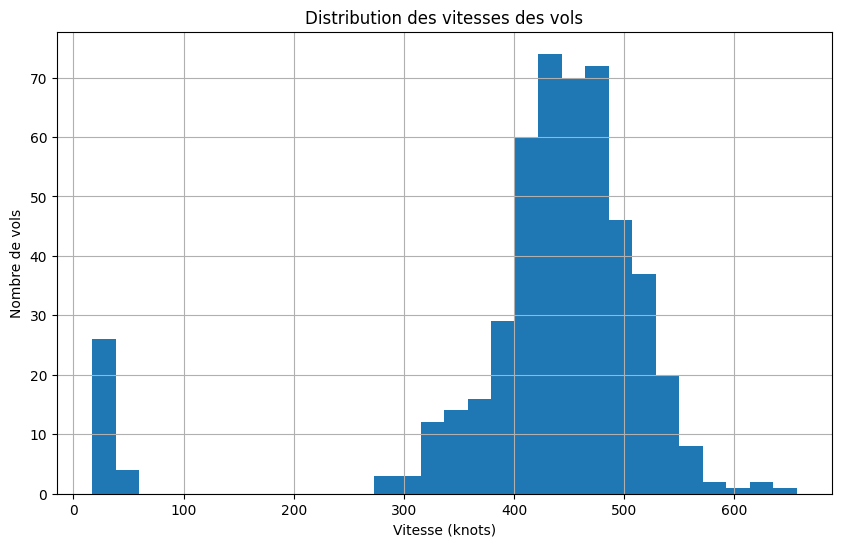

In [8]:
plt.hist(df['velocity_knots'], bins=30)
plt.xlabel('Vitesse (knots)')
plt.ylabel('Nombre de vols')
plt.title('Distribution des vitesses des vols')
plt.show()


## 5. Distribution des altitudes (pieds)

Ce graphique montre la répartition des altitudes de vol.
En pratique, de nombreux vols commerciaux se situent entre 30 000 et 40 000 ft.
Les altitudes plus basses correspondent aux phases de montée, de descente ou à la proximité des aéroports.
On remarque également une accumulation à 0 ft correspondant aux avions au sol.


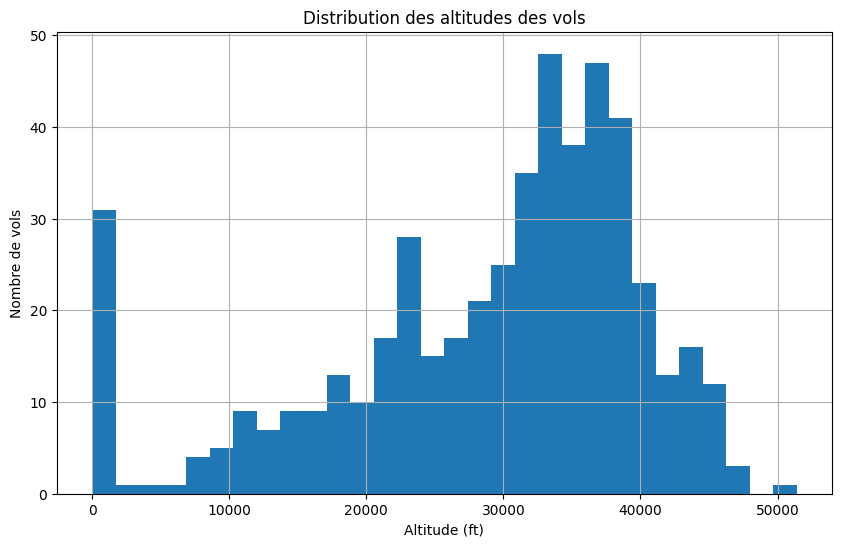

In [9]:
plt.hist(df['geo_altitude_ft'], bins=30)
plt.xlabel('Altitude (ft)')
plt.ylabel('Nombre de vols')
plt.title('Distribution des altitudes des vols')
plt.show()


## 6. Relation entre vitesse et altitude

Ici, chaque point représente un avion, positionné selon :
- son altitude (axe vertical),
- sa vitesse (axe horizontal).

Ce nuage de points permet de voir si certaines altitudes correspondent à des vitesses plus élevées
et d'identifier des groupes (par exemple, vols en croisière vs vols en montée/descente vs avions au sol).


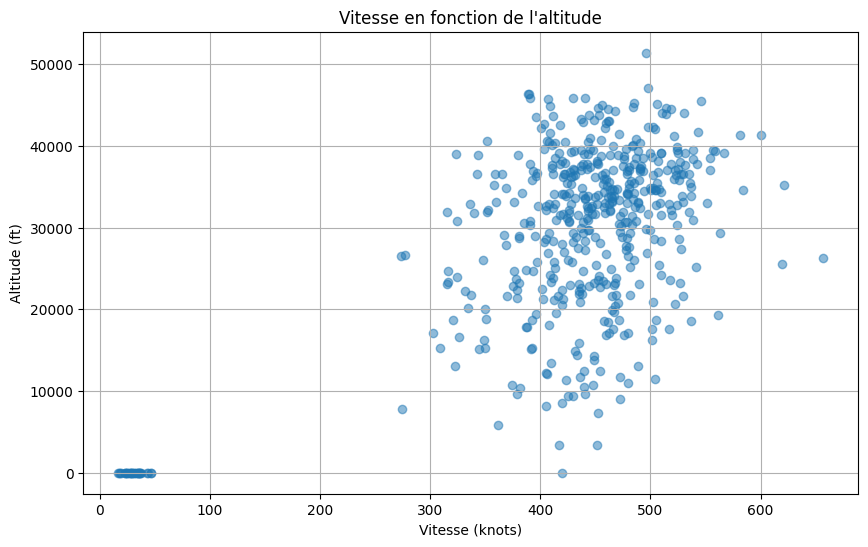

In [10]:
plt.scatter(df['velocity_knots'], df['geo_altitude_ft'], alpha=0.5)
plt.xlabel('Vitesse (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Vitesse en fonction de l\'altitude')
plt.show()


## 7. Heatmap vitesse × altitude (2D)

Pour mieux visualiser les zones de forte densité, nous utilisons un **histogramme 2D**.
Chaque case représente une combinaison de vitesse et d'altitude, et la couleur indique
le nombre de vols dans cette zone.

Ce type de graphique est l'équivalent "statique" de la heatmap altitude/vitesse de l'application.


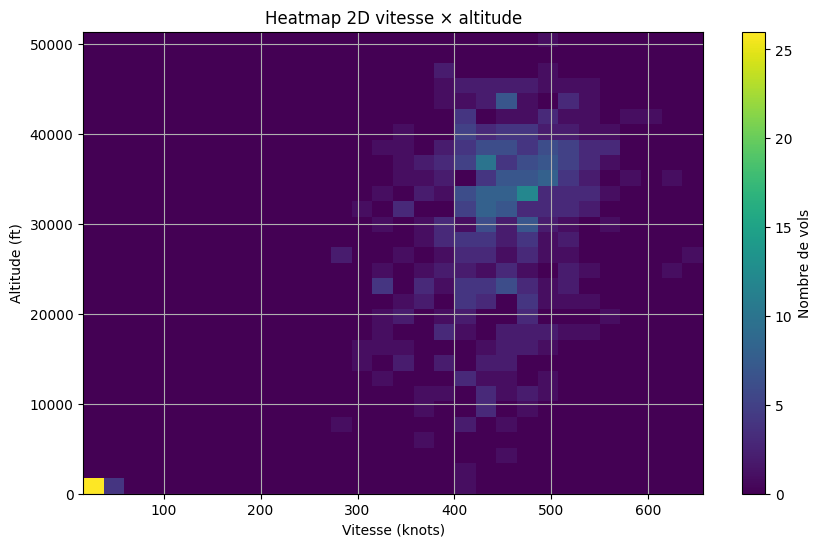

In [11]:
plt.hist2d(df['velocity_knots'], df['geo_altitude_ft'], bins=30)
plt.xlabel('Vitesse (knots)')
plt.ylabel('Altitude (ft)')
plt.title('Heatmap 2D vitesse × altitude')
plt.colorbar(label='Nombre de vols')
plt.show()


## 8. Répartition des vols par pays d'origine

Ce graphique en barres permet de voir **quels pays sont les plus représentés** dans notre jeu de données.
Dans le vrai projet, cette information est utilisée pour construire le graphique "Top 10 pays".


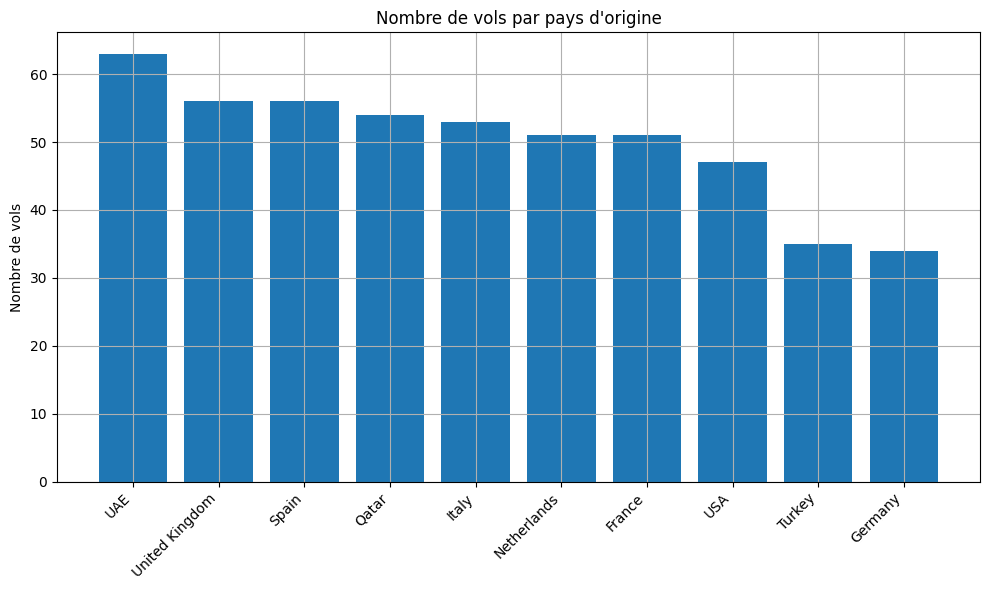

In [12]:
country_counts = df['origin_country'].value_counts().sort_values(ascending=False)

plt.bar(country_counts.index, country_counts.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Nombre de vols')
plt.title('Nombre de vols par pays d\'origine')
plt.tight_layout()
plt.show()


## 9. Répartition des phases de vol

Nous pouvons aussi étudier la proportion de vols en **Montée**, **Descente**, **Croisière** ou **Au sol**.
On vérifie visuellement que l'on reste proche des proportions imposées lors de la génération.


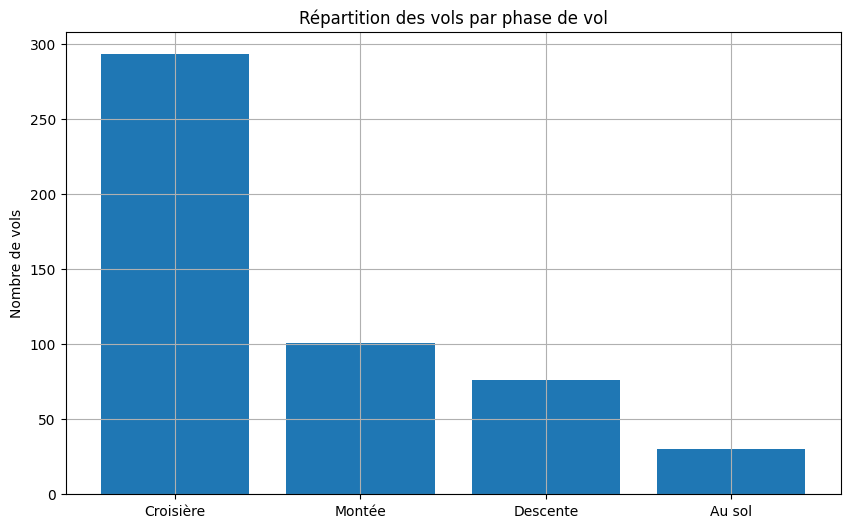

In [13]:
status_counts = df['status'].value_counts()

plt.bar(status_counts.index, status_counts.values)
plt.ylabel('Nombre de vols')
plt.title('Répartition des vols par phase de vol')
plt.show()


## 10. Comparaison par phase de vol (boxplots)

Pour aller plus loin, on compare les distributions :
- des vitesses par phase de vol,
- des altitudes par phase de vol.

Les **boxplots** (boîtes à moustaches) permettent de visualiser les médianes,
les quartiles et les valeurs extrêmes pour chaque catégorie.


/tmp/ipython-input-413776558.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_speed, labels=statuses_unique)


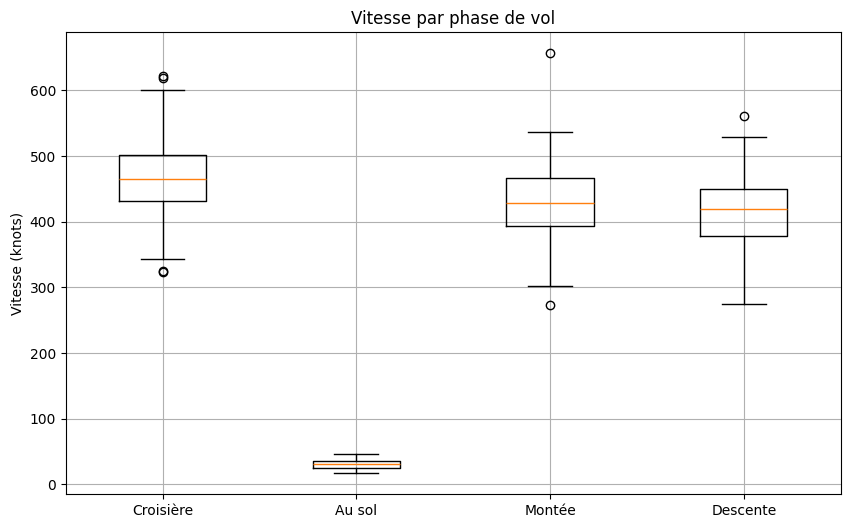

In [14]:
statuses_unique = df['status'].unique()
data_speed = [df[df['status'] == s]['velocity_knots'] for s in statuses_unique]

plt.boxplot(data_speed, labels=statuses_unique)
plt.ylabel('Vitesse (knots)')
plt.title('Vitesse par phase de vol')
plt.show()


/tmp/ipython-input-2967475834.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_alt, labels=statuses_unique)


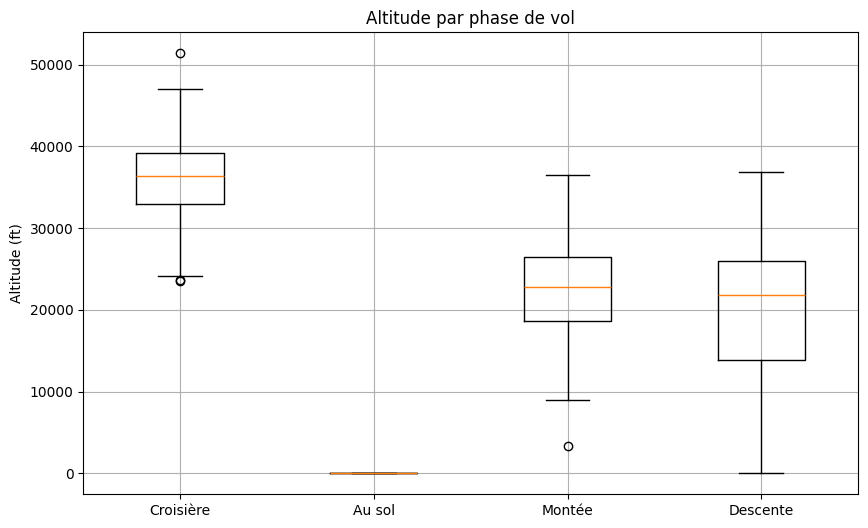

In [15]:
data_alt = [df[df['status'] == s]['geo_altitude_ft'] for s in statuses_unique]

plt.boxplot(data_alt, labels=statuses_unique)
plt.ylabel('Altitude (ft)')
plt.title('Altitude par phase de vol')
plt.show()


## 11. Conclusion de l'exploration

Ce notebook a permis de :

- reconstruire un **jeu de données fictif** proche de celui utilisé en temps réel dans l'application Streamlit,
- imposer des proportions réalistes entre vols en croisière, montée, descente et au sol,
- garantir que les avions au sol ont bien une **altitude nulle**,
- appliquer les **mêmes transformations** (conversions d'unités, statuts),
- explorer la structure via des graphiques simples mais informatifs : histogrammes, nuages de points,
  heatmap 2D, barres, boxplots.

Dans le projet final, ces analyses sont intégrées de manière interactive dans le dashboard Flight Tracker Pro
et mises à jour en temps réel grâce à l'API OpenSky.
